# Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [167]:
import pandas as pd

In [168]:
daily_total_female_births_in_cal = pd.read_csv("daily-total-female-births-in-cal.csv")
international_airline_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_air_temperature_deg = pd.read_csv("mean-monthly-air-temperature-deg.csv")
monthly_boston_armed_robberies_j = pd.read_csv("monthly-boston-armed-robberies-j.csv")
monthly_sales_of_company_x_jan_6 = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
weekly_closings_of_the_dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

In [170]:
all_series = {
    "Daily total female births in cal": daily_total_female_births_in_cal["Count"],
    "International airline passengers": international_airline_passengers["Count"],
    "Mean monthly air temperature deg": mean_monthly_air_temperature_deg["Deg"],
    "Monthly boston armed robberies j": monthly_boston_armed_robberies_j["Count"],
    "Monthly sales of company x jan 6": monthly_sales_of_company_x_jan_6["Count"],
    "Weekly closings of the dowjones": weekly_closings_of_the_dowjones["Close"]
}

In [171]:
series = international_airline_passengers["Count"]

In [172]:
series.head()

0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64

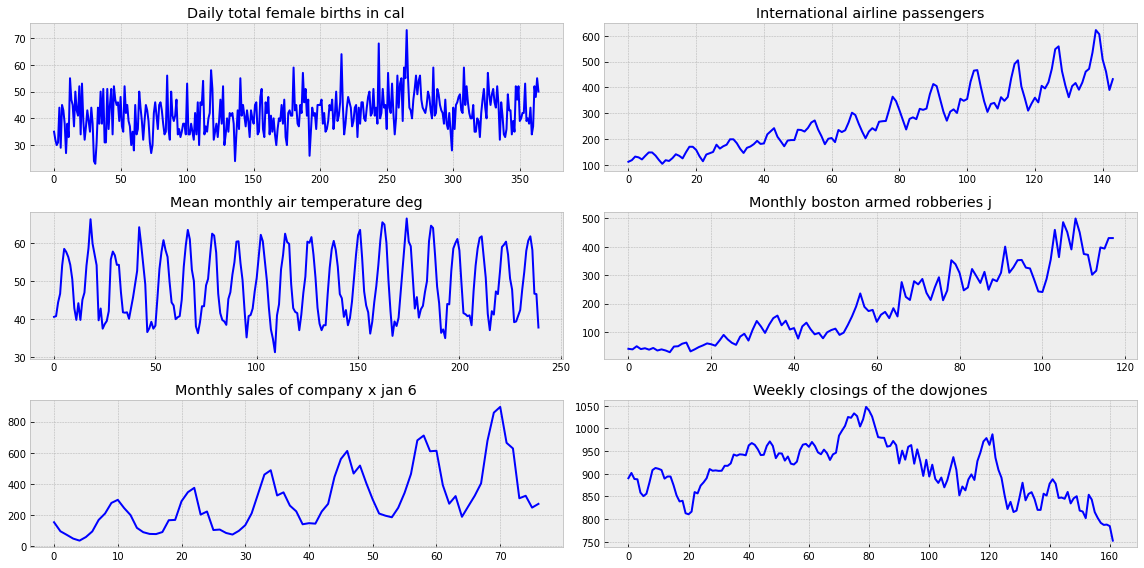

In [173]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [174]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [175]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [176]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [177]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [178]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [179]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [180]:
def plot_tema(alpha, beta, gamma, ser=international_airline_passengers["Count"], ser_to_plot=international_airline_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

# Кросс-валидация

In [181]:
train, val = series[:120], series[120:]

In [182]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [183]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

C:\Users\CoreI7\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


31375.80120395026------------
30955.41050559616------------
31375.80120395026------------
31341.31313195841------------
31074.832580877865------------
30874.968726182782------------
30631.45302930224------------
30447.434090204984------------
30024.386728734433------------
29999.50159683146------------
29482.965068658752------------
29190.47971085728------------
28400.66811902101------------
28061.171944226273------------
26953.29843166105------------
26644.157391275377------------
25242.158083193342------------
24704.398006461804------------
23066.713811915994------------
22373.51974717551------------
20510.73423221117------------
20027.210684139613------------
18466.78348677544------------
18327.265833914298------------
18081.460989893658------------
17508.25070664109------------
18922.84517585939------------
19246.932159749063------------
18025.55763199147------------
20327.820592208922------------
17710.570287071398------------
17181.86278701172------------
16746.60176934158-------

438.64712422763415------------
438.63773574385465------------
438.63596106294534------------
438.6481876039811------------
438.6337201899216------------
438.63493142854765------------
438.63409892821------------
438.6379469409785------------
438.63285872743626------------
438.6325745265767------------
438.63560839514383------------
438.6341354559375------------
438.6324614897156------------
438.63423290198017------------
438.63227845270916------------
438.6362168301189------------
438.63191347605425------------
438.63330097790254------------
438.63206847026976------------
438.6319892090628------------
438.63149296676005------------
438.6314558711861------------
438.6317159804062------------
438.63313086277276------------
438.63154946490994------------
438.63116685479025------------
438.6311002220437------------
438.6311681217624------------
438.63112687445465------------
438.63128203628247------------
438.6310400392301------------
438.6314286729039------------
438.6310076635291--------

In [184]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[0.02771952, 0.31145848, 1.44066335],
       [0.02771377, 0.31152735, 1.44068645],
       [0.02771681, 0.31143579, 1.44066594],
       [0.02771604, 0.31148991, 1.44072392]]), array([438.63098347, 438.6309839 , 438.63098553, 438.6309874 ]))
           fun: 438.6309834712565
       message: 'Optimization terminated successfully.'
          nfev: 324
           nit: 181
        status: 0
       success: True
             x: array([0.02771952, 0.31145848, 1.44066335])


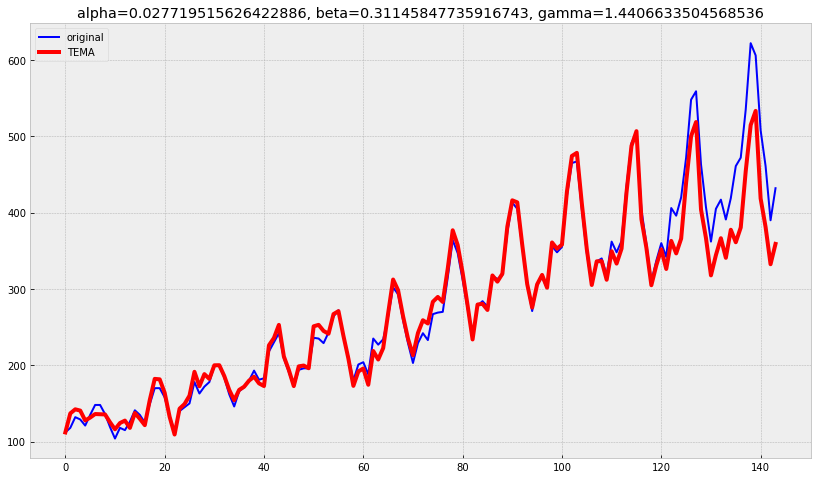

In [185]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Прослеживается тренд и сезонность, получилось похоже

стационарная функция

In [186]:
series = boxcox(all_series["International airline passengers"], 0)

In [187]:
series = np.diff(series, 1)

In [188]:
series = series[12:] - series[:-12]

In [189]:
series

array([ 0.03916403,  0.00036069, -0.02049559, -0.01293918,  0.06614834,
        0.03991464,  0.        ,  0.01135398, -0.03871451, -0.01941809,
        0.07915025,  0.06084382, -0.05744823,  0.05867027, -0.04454824,
        0.13070532, -0.1413435 , -0.02033086,  0.        , -0.00516566,
        0.04490648,  0.05016097, -0.07706281, -0.00541555,  0.01739174,
       -0.10141492,  0.02384019, -0.04275515,  0.14071984, -0.05793703,
        0.05085842, -0.06823441,  0.0372786 , -0.00078924, -0.00801748,
       -0.01941927, -0.05129329,  0.11598381,  0.05994687, -0.03685263,
       -0.11566947,  0.02930341, -0.02100545,  0.00886155, -0.02614118,
       -0.05412233, -0.01001563,  0.00455859, -0.08167803,  0.03742641,
       -0.03038921,  0.05623461,  0.06128855,  0.05159025, -0.06010737,
        0.01439738, -0.00690405,  0.03838526,  0.01016797,  0.04040064,
        0.04377876, -0.08693335,  0.04209822, -0.02666052,  0.03352269,
        0.01010331, -0.01757468,  0.01702296, -0.00676902, -0.02

In [190]:
series = pd.DataFrame(series)

In [191]:
train, val = series[:120], series[120:]

In [192]:
opt = minimize(ex_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

C:\Users\CoreI7\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------
185554.6924195263------------


In [193]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[0.00e+00, 0.00e+00, 0.00e+00],
       [6.25e-05, 0.00e+00, 0.00e+00],
       [0.00e+00, 6.25e-05, 0.00e+00],
       [0.00e+00, 0.00e+00, 6.25e-05]]), array([185554.69241953, 185554.69241953, 185554.69241953, 185554.69241953]))
           fun: 185554.6924195263
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 3
        status: 0
       success: True
             x: array([0., 0., 0.])


получилась очень большая ошибка